
# `Análisis de modelo de clasificación supervisado`

Participantes:
- Fernando Sierra
- Diego Valdivia
- Cristian Valenzuela

### `Importar las bibliotecas necesarias `

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io.arff as arff
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score


### `Funciones`


In [2]:

def graficos_univariados(df, variable):
    # Configurar el tamaño de la figura
    plt.figure(figsize=(10, 4))

    # Crear subplots: 1 fila, 2 columnas
    plt.subplot(1, 2, 1)
    # Histograma usando Seaborn
    sns.histplot(df[variable], kde=True, color="lightblue", alpha=0.8)
    plt.title('Histograma de ' + variable)

    plt.subplot(1, 2, 2)
    # Boxplot usando Seaborn
    sns.boxplot(y=df[variable], color="lightblue")
    plt.title('Boxplot de ' + variable)

    # Mejorar layout y mostrar la figura
    plt.tight_layout()
    plt.show()


def elimina_outliers(df, columnas, umbral):
    """
    Elimina outliers del Dataset basado en el Z-Score.
    Parámetros:
    - df: Dataset a tratar.
    - columnas: Lista con los nombres de las columnas a analizar.
    - umbral: Umbral del Z-Score para identificar outliers.
    Retorna:
    - datos_filtrados: DataFrame sin outliers.
    """
    indices_a_eliminar = set()
    
    for columna in columnas:
        # Calcular el Z-Score para cada columna
        z_scores = stats.zscore(df[columna])
        
        # Identificar índices de outliers y agregarlos al conjunto
        indices_a_eliminar.update(df[abs(z_scores) > umbral].index)
        #print(f"Outliers eliminados de {columna}: {len(indices_a_eliminar)}")
    
    # Imprimir el número de outliers identificados
    print("Total de valores atípicos eliminados por Z-Score:", len(indices_a_eliminar))
    
    # Elimina outliers del DataFrame usando los índices identificados
    df_filtrados = df.drop(index=indices_a_eliminar)
    
    return df_filtrados


def graf_matriz_confusion(pred_default, pred_hp, name_model):
    # Calcula matrices de confusión
    conf_matrix_default = confusion_matrix(y_test, pred_default)
    conf_matrix_hp = confusion_matrix(y_test, pred_hp)
    # Configurar la visualización
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    # Títulos de los subplots
    ax[0].set_title(name_model + ' Sin Ajuste de Hiperparámetros')
    ax[1].set_title(name_model + ' Con Ajuste de Hiperparámetros')

    class_labels = ['Cammeo', 'Osmancik']
    # Visualización de la matriz de confusión para el modelo sin ajuste de hiperparámetros
    sns.heatmap(conf_matrix_default, annot=True, fmt='d', cmap='Blues', ax=ax[0], cbar=False, xticklabels=class_labels, yticklabels=class_labels)
    ax[0].set_xlabel('Predicciones')
    ax[0].set_ylabel('Verdaderos')

    # Visualización de la matriz de confusión para el modelo con ajuste de hiperparámetros
    sns.heatmap(conf_matrix_hp, annot=True, fmt='d', cmap='Greens', ax=ax[1], cbar=False, xticklabels=class_labels, yticklabels=class_labels)
    ax[1].set_xlabel('Predicciones')
    ax[1].set_ylabel('Verdaderos')

    plt.show()
    

def graf_feature_importances(df):
    # Orden por importancia
    features_df = df.sort_values(by='Importance', ascending=False)

    # Porcentaje
    features_df['Importance_Percentage'] = 100 * (features_df['Importance'] / features_df['Importance'].sum())

    # Suma acumulada
    features_df['Cumulative_Importance'] = features_df['Importance_Percentage'].cumsum()

    # Gráfico
    plt.figure(figsize=(12, 4))
    plt.plot(features_df['Feature'], features_df['Cumulative_Importance'], marker='o', drawstyle="steps-post")
    plt.xticks(rotation=90) 
    plt.xlabel('Características')
    plt.ylabel('Importancia Acumulada (%)')
    plt.title('Importancia Acumulada de las Características')
    plt.grid(True)

    # Linea roja al 80%
    plt.axhline(y=80, color='r', linestyle='--')
    plt.xlim([-1, len(features_df)])

    plt.show()

### `Lectura de base de datos y primeros valores del dataframe`

In [3]:
archivo_arff = 'Rice_Cammeo_Osmancik.arff'
datos = pd.DataFrame(arff.loadarff(open(archivo_arff, 'rt'))[0])
display(datos.head(5))
display(datos.columns)

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,15231.0,525.578979,229.749878,85.093788,0.928882,15617.0,0.572896,b'Cammeo'
1,14656.0,494.311005,206.020065,91.730972,0.895405,15072.0,0.615436,b'Cammeo'
2,14634.0,501.122009,214.106781,87.768288,0.912118,14954.0,0.693259,b'Cammeo'
3,13176.0,458.342987,193.337387,87.448395,0.891861,13368.0,0.640669,b'Cammeo'
4,14688.0,507.166992,211.743378,89.312454,0.906691,15262.0,0.646024,b'Cammeo'


Index(['Area', 'Perimeter', 'Major_Axis_Length', 'Minor_Axis_Length',
       'Eccentricity', 'Convex_Area', 'Extent', 'Class'],
      dtype='object')

In [4]:
datos.describe()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent
count,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000
mean,12667.727559,454.239180,188.776222,86.313750,0.886871,12952.496850,0.661934
std,1732.367706,35.597081,17.448679,5.729817,0.020818,1776.972042,0.077239
min,7551.000000,359.100006,145.264465,59.532406,0.777233,7723.000000,0.497413
25%,11370.500000,426.144753,174.353855,82.731695,0.872402,11626.250000,0.598862
50%,12421.500000,448.852493,185.810059,86.434647,0.889050,12706.500000,0.645361
75%,13950.000000,483.683746,203.550438,90.143677,0.902588,14284.000000,0.726562
max,18913.000000,548.445984,239.010498,107.542450,0.948007,19099.000000,0.861050


Las 7 variables numéricas tienen valores en rangos razonables desde su media, indicando que todos los datos parecen tener datos bien distribuidos y razonable, esto es señal de que son útiles modelar. La variable `Class` (que indica si el grano es `Cammeo` u `Osmancik`) será nuestra `variable objetivo` para la clasificación.

### `Tratamiento de duplicados y valores faltantes`: 


In [5]:
# Revisión de datos faltantes y tipo de variables
datos.info()
#Revisamos si hay duplicados
print()
print("Número de datos duplicados:", len(datos[datos.duplicated()]), ", de un total de", len(datos))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3810 entries, 0 to 3809
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Area               3810 non-null   float64
 1   Perimeter          3810 non-null   float64
 2   Major_Axis_Length  3810 non-null   float64
 3   Minor_Axis_Length  3810 non-null   float64
 4   Eccentricity       3810 non-null   float64
 5   Convex_Area        3810 non-null   float64
 6   Extent             3810 non-null   float64
 7   Class              3810 non-null   object 
dtypes: float64(7), object(1)
memory usage: 238.3+ KB

Número de datos duplicados: 0 , de un total de 3810


#### Dado que no hay `datos faltantes` y tampoco `datos duplicados` procedemos al siguiente paso.


Class
Osmancik    2180
Cammeo      1630
Name: count, dtype: int64

Class
Osmancik    0.572178
Cammeo      0.427822
Name: proportion, dtype: float64

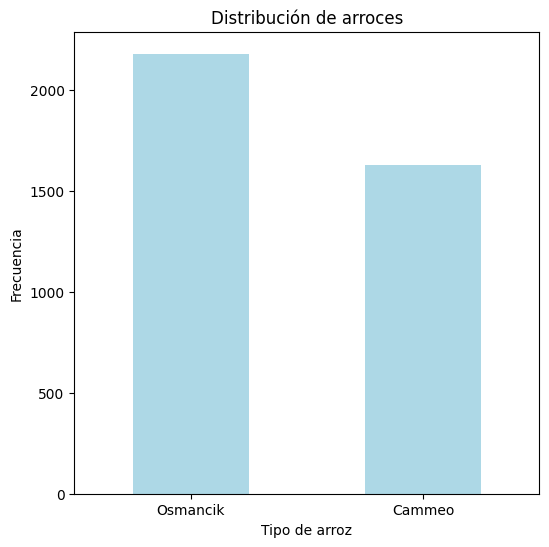

In [6]:
# Se corrige los valores de la columna 'Class' eliminando los caracteres extraños
datos['Class'] = datos['Class'].str.decode("utf-8").str.replace("b'", "").str.replace("'", "")

#Estadisticas de variable respuesta.
display(datos.Class.value_counts(), datos.Class.value_counts('%'))

plt.figure(figsize=(6, 6))
datos['Class'].value_counts().plot(kind='bar', color="lightblue")
plt.xlabel('Tipo de arroz')
plt.ylabel('Frecuencia')
plt.title('Distribución de arroces')
plt.xticks(rotation=0)
plt.show()

En los gráficos se puede observar que existe más data de Osmancik que de Cammeo, pero la diferencia no es tan extrema (57% y 43% respectivamente). Por ende, por ahora no se requerirá técnicas de balanceo de clases, pero esto se puede retomar al evaluar el rendimiento del modelo.  

### `Revisaremos las variables independientes`:

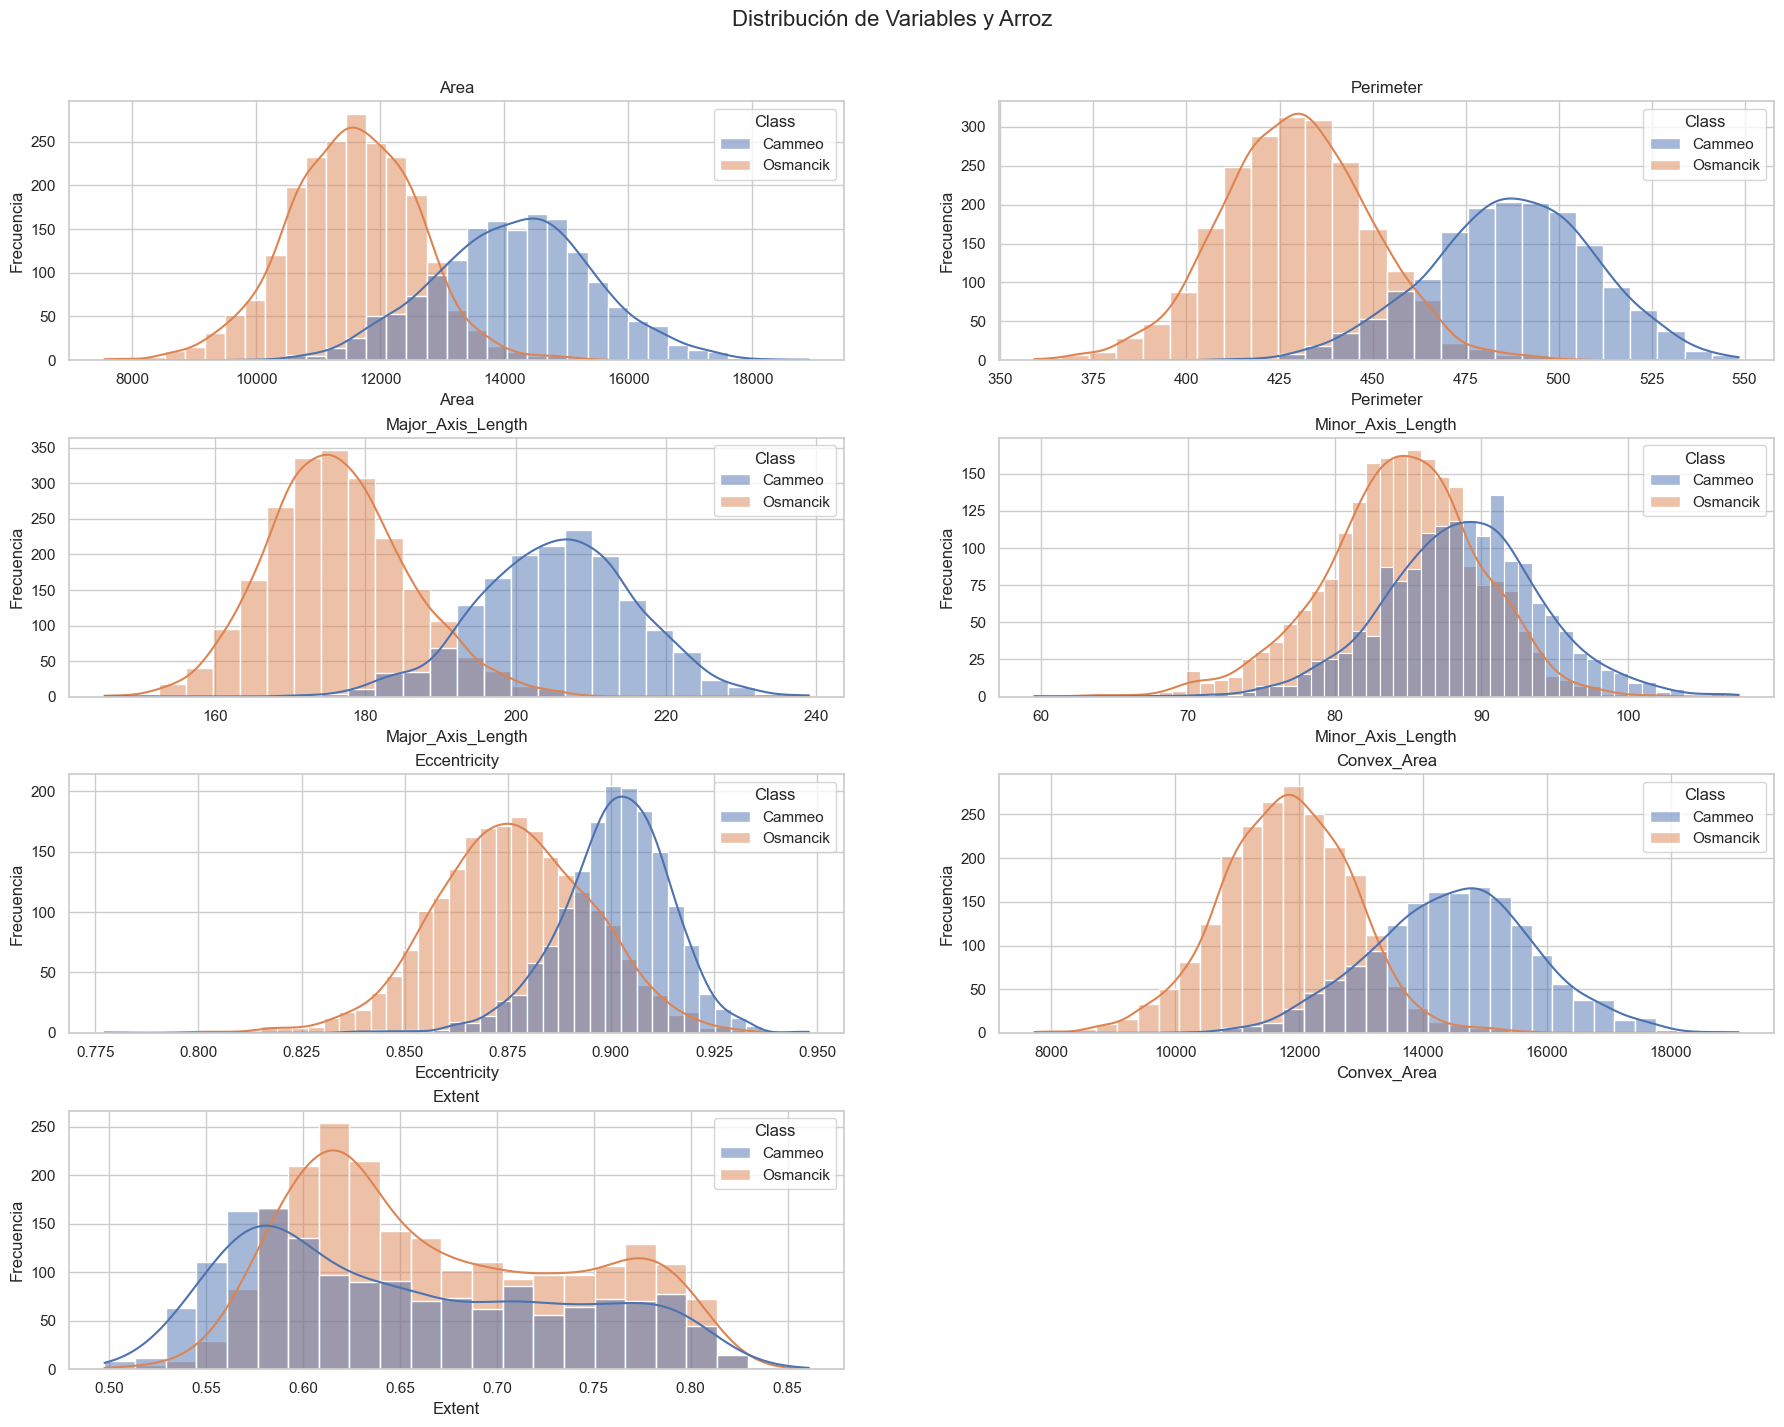

In [7]:
sns.set(style="whitegrid")

# Graficos de densidad
fig, axes = plt.subplots(4, 2, figsize=(18, 15))
fig.suptitle('Distribución de Variables y Arroz', fontsize=16)

# variables númericas
num_vars = ['Area', 'Perimeter', 'Major_Axis_Length', 'Minor_Axis_Length', 'Eccentricity', 'Convex_Area', 'Extent']

# Generamos gráficos para cada variable
for ax, var in zip(axes.flat, num_vars):
    sns.histplot(datos, x=var, hue="Class", ax=ax, kde=True)
    ax.set_title(var)
    ax.set_ylabel('Frecuencia')

# Eliminar el subplot vacío
fig.delaxes(axes[3][1])

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.subplots_adjust(wspace=0.2, hspace=0.3)
plt.show()


Las distribuciones de Cammeo tienden a estar centradas en medias más altas que Osmancik, esto es la mayoría de las variables (con excepción de `Extent`).
 
Algunas variables como `Area`, `Perimeter`, `Major_Axis_Length` y `Convex_Area` y `Eccentricity`, muestran distribuciones bien separadas, lo cual nos podrían ayudar a diferenciar entre las dos clases de arroz. Por otro lado, `Minor_Axis_Length` y `Extent` tienen distribuciones y medias muy similares, lo cual no entregan mucha información si se quiere segregar por clases. 

Se destaca `Eccentricity`, la cual la que ofrecer alguna diferenciación, aunque con una superposición más significativa entre las clases.

### `Revisión variables univariadas`

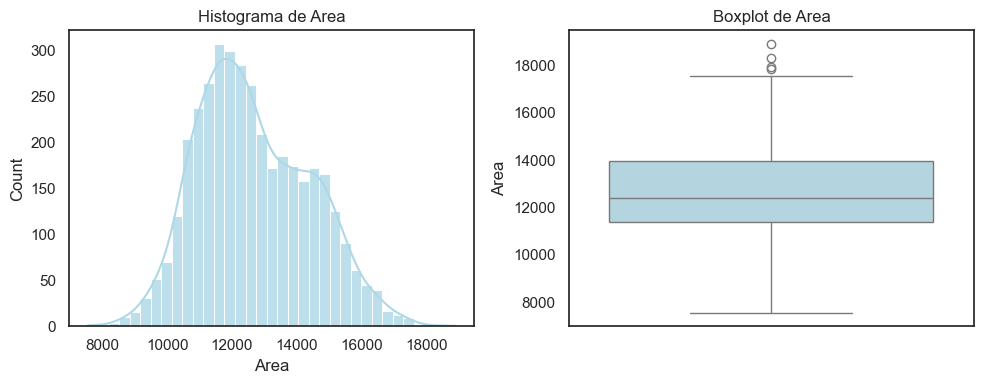

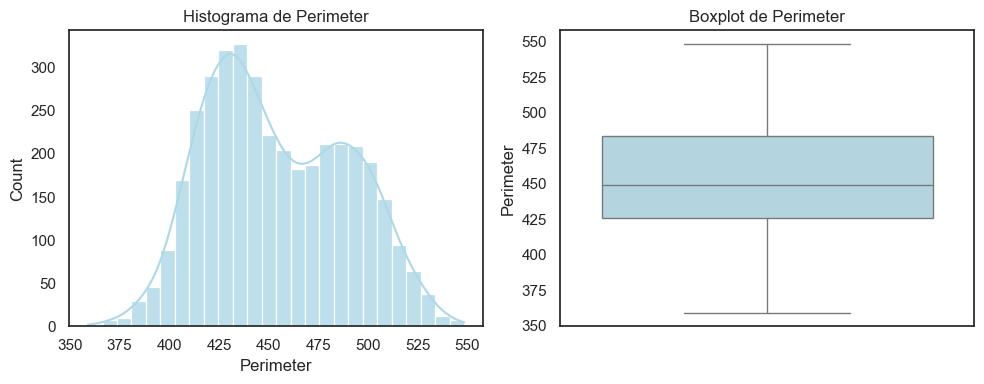

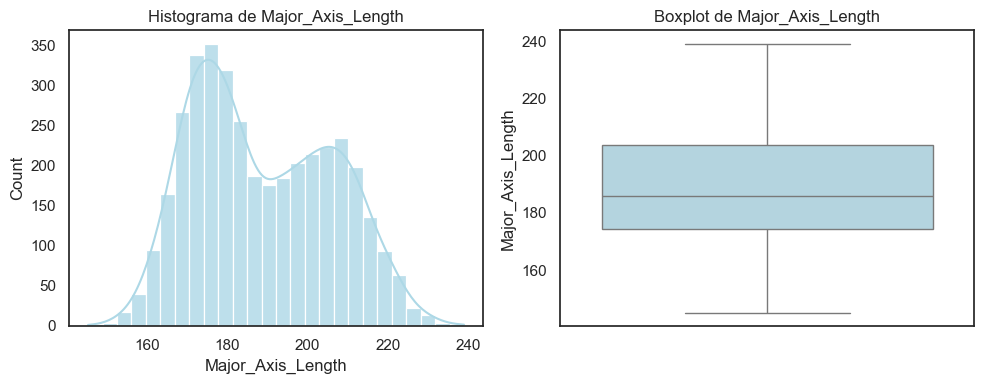

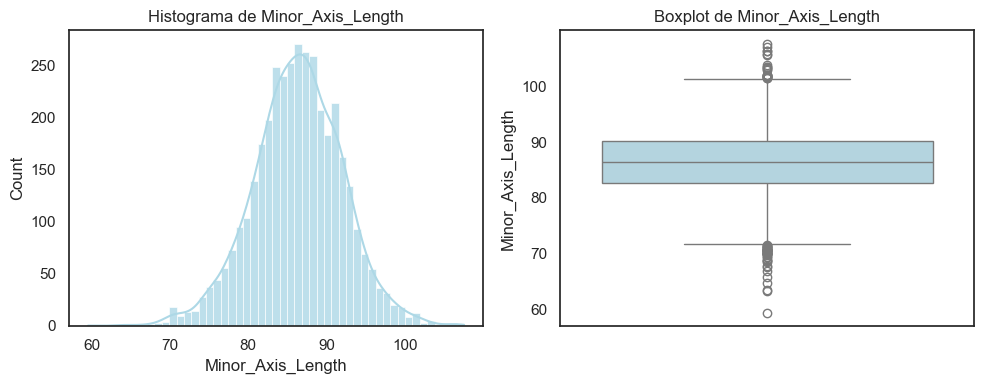

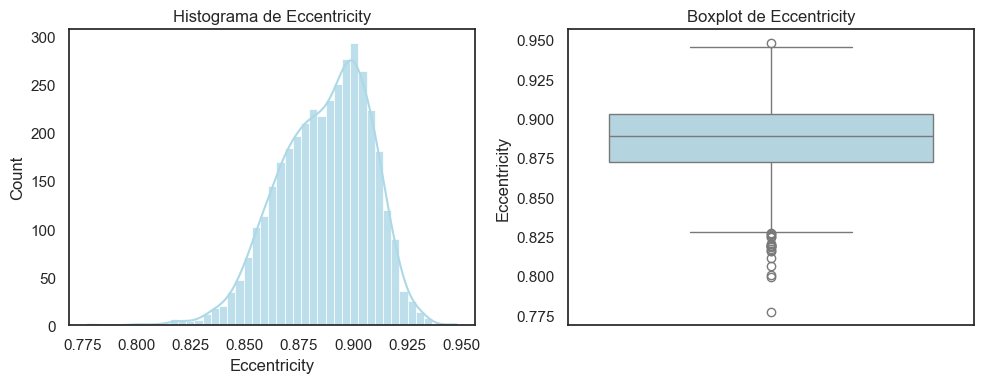

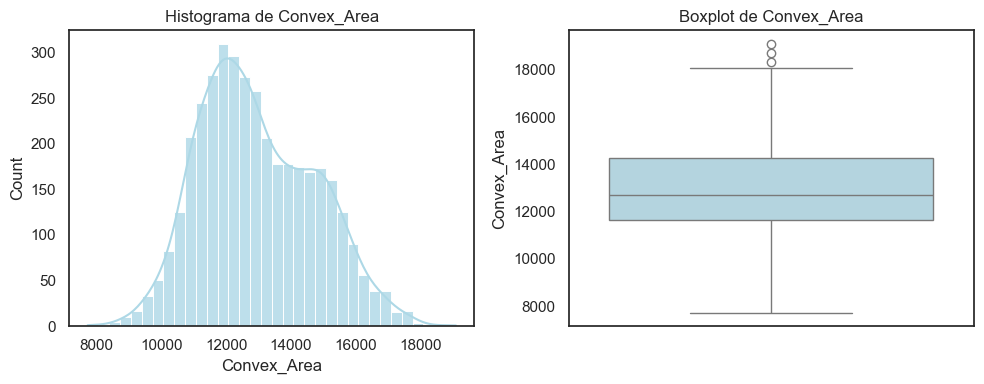

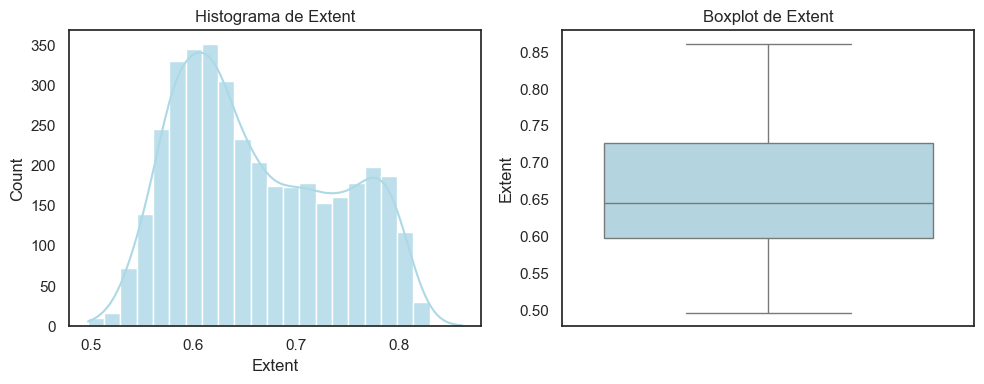

In [8]:
sns.set(style="white")
graficos_univariados(datos, 'Area')
graficos_univariados(datos, 'Perimeter')
graficos_univariados(datos, 'Major_Axis_Length')
graficos_univariados(datos, 'Minor_Axis_Length')
graficos_univariados(datos, 'Eccentricity')
graficos_univariados(datos, 'Convex_Area')
graficos_univariados(datos, 'Extent')

Algunos puntos interesantes de las variables:

- El histograma de `Area` sugiere una distribución con sesgo positivo y una concentración de valores en torno a un pico central (media de 12667.72). El boxplot revela varios valores atípicos altos y una mediana más cercana al cuartil inferior.

- `Minor_Axis_Length` muestra una distribución que parece normal y simétrica. El boxplot muestra una dispersión uniforme alrededor de la mediana y varios valores atípicos en la parte superior e inferior.

- El histograma para `Eccentricity` muestra una distribución asimétrica con sesgo hacia la izquierda, concentrándose la mayoría de los datos cerca del extremo superior del rango. El boxplot correspondiente revela una mediana alta y valores atípicos en el extremo inferior, lo que respalda la asimetría observada en el histograma.


### `Tratamiento de outliers`

Vamos a realizar un tratamiento de outliers para las variables `Eccentricity` y `Minor_Axis_Length`. Se ejecuto el `Z-score` con un umbral de `2.5`, con el cual se eliminaron `111 outliers` (2.9% del total del dataset).

In [9]:
# Z score para Eccentricity y Minor_Axis_Length
datos_filtrados = elimina_outliers(datos, ['Eccentricity', 'Minor_Axis_Length'], 2.5)


Total de valores atípicos eliminados por Z-Score: 111


Se muestra la distribución de las variables modificada por la eliminación de valores atípicos. Se menciona `Area`, ya que el tratamiento de outliers afecta indirectamente sus valores atípicos.

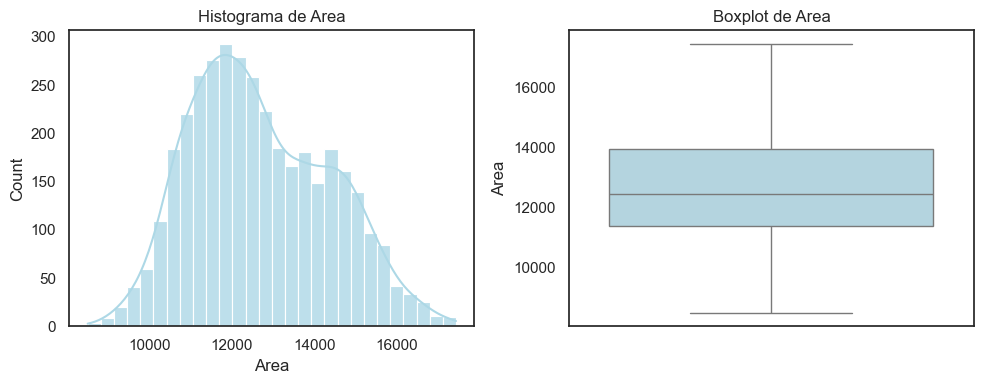

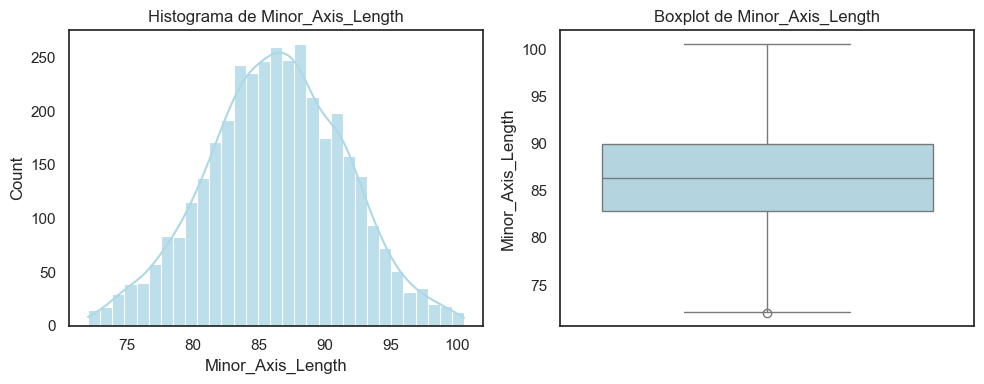

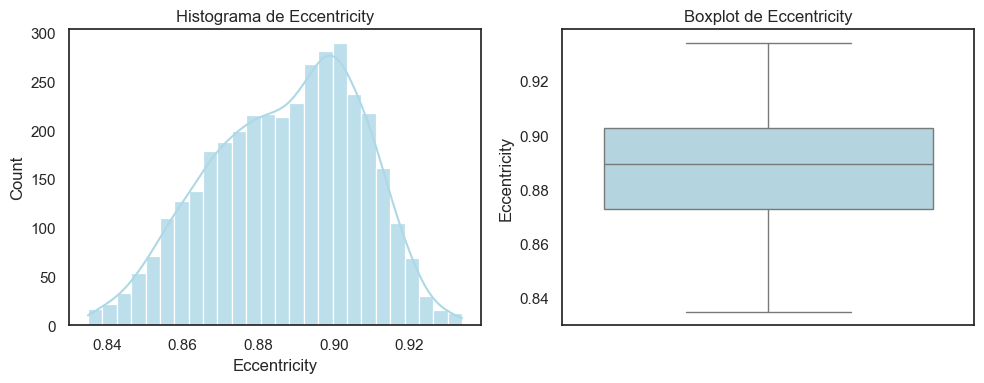

In [10]:
sns.set(style="white")
graficos_univariados(datos_filtrados, 'Area')
graficos_univariados(datos_filtrados, 'Minor_Axis_Length')
graficos_univariados(datos_filtrados, 'Eccentricity')

### `Correlación entre variables`

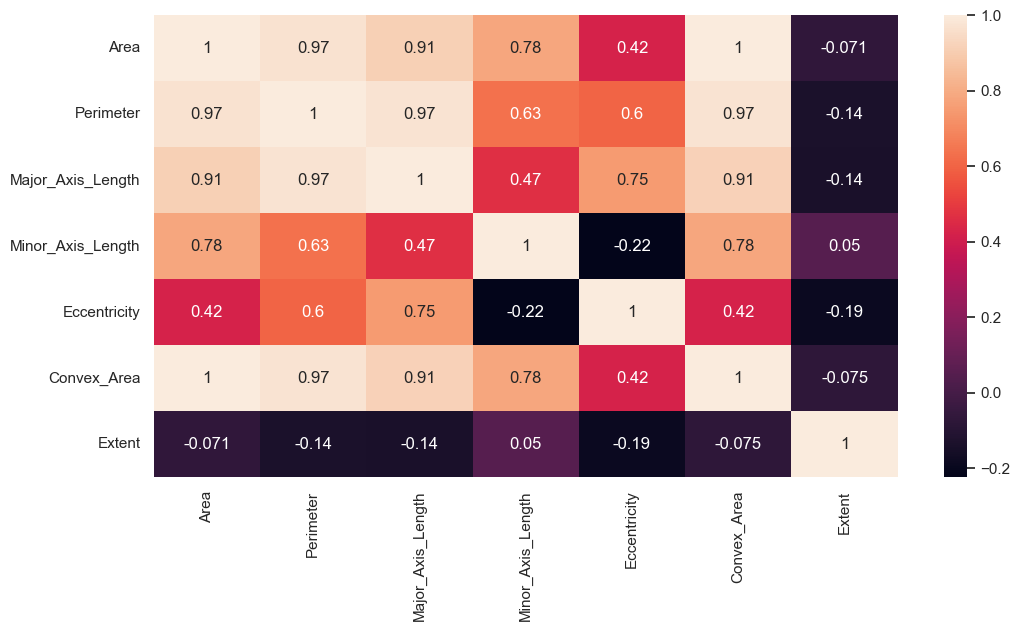

In [11]:
plt.figure(figsize=(12, 6))
ax = sns.heatmap(datos_filtrados.drop("Class", axis=1).corr(method='pearson'),annot=True)
plt.show()

La matriz de correlación revela algunos puntos interesantes sobre las variables:

- Alta correlación entre `Area`, `Perimeter`, `Major_Axis_Length`, y `Convex_Area`, lo que indica que estas medidas están fuertemente relacionadas entre sí. Esta información parece lógica ya que las variables para calcular dichos valores son los mismos, como lo son el radio o el eje de la elipse.

- `Eccentricity` muestra una correlación positiva moderada con `Perimeter` y `Major_Axis_Length`, lo que sugiere que cuanto más alargado es el grano, mayor es su excentricidad.

- `Extent` muestra correlaciones bajas o negativas con las otras medidas, indicando que esta variable aporta una dimensión de variación diferente y no está directamente relacionada con el tamaño o la forma lineal del grano.

### `Ingeniera de características`


Crearemos algunas variables que quiza nos puedan aportar al modelo:
- La `relación de aspecto` puede indicar la elongación de los granos de arroz. Podría calcularse dividiendo el Major_Axis_Length y Minor_Axis_Length.
- La `compacidad` podría indicar cuán compacto es un grano de arroz, y se puede calcular como el cuadrado del perímetro dividido por el área.
- La `circularidad` es una medida de cuán cercano es el grano de arroz a una forma circular, y se podría calcular usando el área y el perímetro.

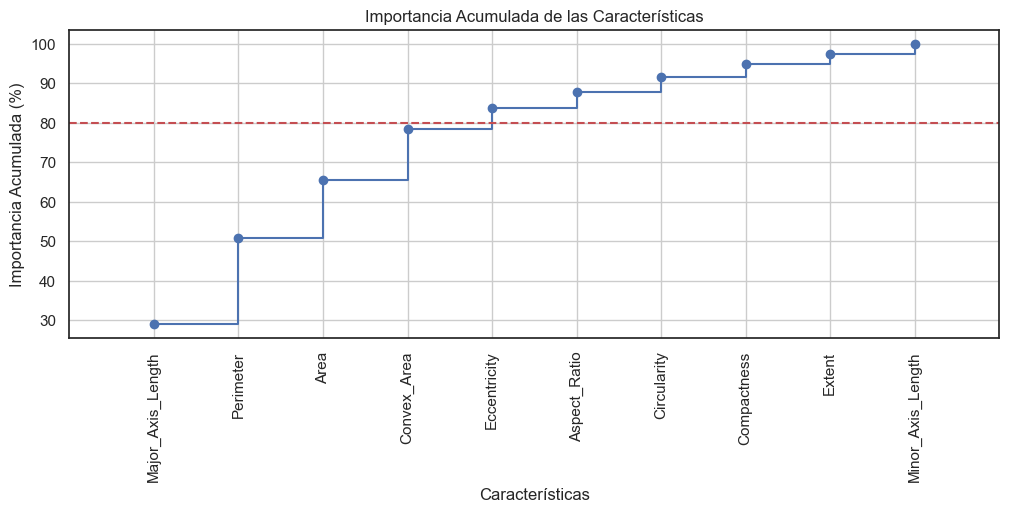

In [12]:
# Agregando nuevas características
datos_filtrados['Aspect_Ratio'] = datos_filtrados['Major_Axis_Length'] / datos_filtrados['Minor_Axis_Length']
datos_filtrados['Compactness']  = (datos_filtrados['Perimeter']**2) / datos_filtrados['Area']
datos_filtrados['Circularity']  = (4 * np.pi * datos_filtrados['Area']) / (datos_filtrados['Perimeter']**2)


# Preparar los datos para el modelo
X = datos_filtrados.drop(['Class'], axis=1)  # Excluyendo la variable objetivo
y = datos_filtrados['Class']  # Variable objetivo

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenar un modelo Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Obtener la importancia de las características
feature_importances = rf.feature_importances_

# Visualizar la importancia de las características
importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Graficamos
graf_feature_importances(importances_df)


Uno de los análisis que se pueden realizar, es la ingeniería de características, de donde realizamos la creación de algunas variables y un gráfico de `features importances`, donde se puede concluir que con 5 variables podemos explicar un poco más del 80 % del modelo.

Este criterio será impuesto a los de correlación, ya que el aporte de la variable `Extent` se considera mínimo. Por otro lado, lo comentado de la multicolinealidad lo analizaremos con el performance del modelo.


### `Selección de las variables, división de conjunto de datos y Estandarización `

La pregunta importante que hay que responder es: "¿Qué tipo de modelo debemos utilizar?". Esto nos ayudará a manejar la complejidad de las variables. Puede que tengamos que buscar modelos como `SVM` o `árboles de decisión`, que pueden manejar bien estos casos.  

- `Selección de Variables`: Nos centraremos en `Major_Axis_Length`, `Perimeter`, `Area`, `Convex_Area` y `Eccentricity` como variables independientes.

- `Codificación de la Variable Objetivo`: Convertiremos `Class` a una variable a 0 y 1 (0 = “Cammeo” y 1= “Osmancik”).

- `División de Datos`: Separaremos los datos en conjuntos de entrenamiento y prueba (`80%` y `20%` respectivamente).

- `Estandarizaremos`: Las variables nombradas en los puntos anteriores, esto es con el fin de buscar que los modelos se benefician de este proceso, como SVM.

In [13]:
# Selección de variables
#X = datos_filtrados[['Area', 'Convex_Area', 'Eccentricity', 'Extent']]
#X = datos_filtrados[['Area', 'Perimeter', 'Major_Axis_Length', 'Minor_Axis_Length', 'Convex_Area', 'Eccentricity', 'Extent']]
X = datos_filtrados[['Major_Axis_Length', 'Perimeter', 'Area', 'Convex_Area', 'Eccentricity']]
y = datos_filtrados['Class']

# 0 = Cammeo y 1 =  de la variable objetivo
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Set de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=2024)

# Estadarización
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)


# Dimensiones
X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape

((2959, 5), (740, 5), (2959,), (740,))

In [14]:
X_train_scaled.describe()

,Major_Axis_Length,Perimeter,Area,Convex_Area,Eccentricity
count,2.959000e+03,2.959000e+03,2.959000e+03,2.959000e+03,2.959000e+03
mean,-3.409837e-16,-7.684139e-17,-2.527361e-16,1.945048e-16,1.410760e-16
std,1.000169e+00,1.000169e+00,1.000169e+00,1.000169e+00,1.000169e+00
min,-2.253105e+00,-2.444018e+00,-2.419514e+00,-2.400906e+00,-2.659937e+00
25%,-8.264262e-01,-7.883207e-01,-7.617696e-01,-7.646930e-01,-7.322361e-01
50%,-1.812502e-01,-1.554341e-01,-1.509903e-01,-1.463600e-01,9.133602e-02
75%,8.413370e-01,8.334577e-01,7.609788e-01,7.691471e-01,7.554982e-01
max,2.913949e+00,2.646254e+00,2.854308e+00,2.800813e+00,2.387340e+00


In [15]:
X_test_scaled.describe()

,Major_Axis_Length,Perimeter,Area,Convex_Area,Eccentricity
count,740.000000,740.000000,740.000000,740.000000,740.000000
mean,0.020374,0.009426,-0.001312,-0.001285,0.046888
std,1.021031,1.030893,1.022438,1.025866,1.010294
min,-2.397514,-2.751477,-2.507711,-2.526679,-2.658978
25%,-0.849292,-0.833339,-0.782319,-0.784729,-0.710431
50%,-0.097217,-0.114101,-0.120991,-0.118573,0.166404
75%,0.919070,0.862021,0.738030,0.760665,0.834300
max,2.880441,2.700500,2.697113,2.694345,2.352082


Las proporciones de los conjuntos de datos de entrenamiento y testeo parecen estar semejantes estadísticamente.

### `Modelo SVM`

In [16]:
svm_model = SVC(random_state=2023) 
svm_model.fit(X_train_scaled, y_train)
pred_values_svm = svm_model.predict(X_test_scaled)

print(classification_report(y_test,pred_values_svm, target_names=label_encoder.classes_))
print(confusion_matrix(y_test,pred_values_svm))

              precision    recall  f1-score   support

      Cammeo       0.91      0.92      0.92       322
    Osmancik       0.94      0.93      0.94       418

    accuracy                           0.93       740
   macro avg       0.93      0.93      0.93       740
weighted avg       0.93      0.93      0.93       740

[[297  25]
 [ 28 390]]


### `Modelo Árbol de decisión`

In [17]:
tree_model = DecisionTreeClassifier(random_state=2023)
tree_model.fit(X_train_scaled, y_train)
pred_values_tree = tree_model.predict(X_test_scaled)

print(classification_report(y_test,pred_values_tree, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

      Cammeo       0.85      0.87      0.86       322
    Osmancik       0.90      0.88      0.89       418

    accuracy                           0.88       740
   macro avg       0.87      0.88      0.87       740
weighted avg       0.88      0.88      0.88       740



In [18]:
print(f"SVM accuracy: {round(accuracy_score(y_test, pred_values_svm), 3)}")
print(f"Tree accuracy: {round(accuracy_score(y_test, pred_values_tree), 3)}")

SVM accuracy: 0.928
Tree accuracy: 0.876


La comparación preliminar de modelos usando `accuracy` como métrica de desempeño arrojó los siguientes resultados:
- `SVM`: 92.8%
- `Decision Tree`: 87.6%


El modelo de `SVM` mostró el mejor rendimiento inicial (`92.8%`). Dado este resultado, parece ser el candidato más prometedor para proceder a la optimización de hiper-parámetros y preliminarmente mejorar aún más su desempeño. Por otro lado, tenemos el `árbol de decisión` que si bien, fue el que tuvo el peor resultado (`87.6%`), pero dadas sus capacidades, puede ser muy bueno si se le asignan los hiper-parámetros adecuados y computacionalmente no es tan costoso como SVM.


### `Hiper-parámetros de modelo SVM`

In [19]:
# Definir el espacio de hiper-parámetros para la búsqueda en cuadrícula
parametros_SVM = {
    'C': [0.001, 0.01, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 200],
    #'degree' : [2,3,4,5,6,7,8,10,15,20,25,30],
    'kernel': ['linear', 'rbf'],
    #'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

# Inicializar GridSearchCV con el modelo SVM y el espacio de hiper-parámetros
grid_search = GridSearchCV(SVC(), parametros_SVM, cv=5, verbose=0)

# Ejecutar la búsqueda en cuadrícula con los datos de entrenamiento
grid_search.fit(X_train_scaled, y_train)

# Mejores hiper-parámetros
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score


({'C': 5, 'gamma': 'scale', 'kernel': 'linear'}, 0.9290311885489551)

La optimización de hiper-parámetros mediante `GridsearchCV` para el modelo SVM ha encontrado la siguiente mejor configuración:
- `C`: 5
- `Gamma`: 'scale'
- `Kernel`: 'linear'

Con un Accuracy promedio de 93% en la validación cruzada, esta configuración ha mostrado el mayor rendimiento. Se utilizarán estos parámetros para entrenar el modelo SVM, evaluando en conjunto las métricas finales de desempeño y la matriz de confusión.

In [20]:
# Entrenar el modelo SVM con los mejores hiper-parámetros encontrados
best_svm = SVC(C=best_params['C'], kernel=best_params['kernel'], gamma=best_params['gamma'])
best_svm.fit(X_train_scaled, y_train)

# Predecir en el conjunto de prueba
pred_values_svm_hp = best_svm.predict(X_test_scaled)

# Calcular métricas de desempeño y matriz de confusión
print(classification_report(y_test, pred_values_svm_hp, target_names=label_encoder.classes_))
#print(confusion_matrix(y_test, pred_values_svm_hp))


              precision    recall  f1-score   support

      Cammeo       0.92      0.94      0.93       322
    Osmancik       0.95      0.94      0.94       418

    accuracy                           0.94       740
   macro avg       0.93      0.94      0.94       740
weighted avg       0.94      0.94      0.94       740



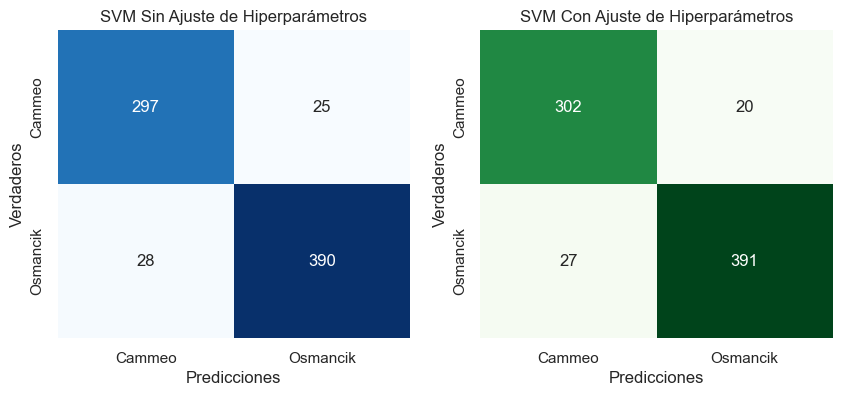

In [21]:
# Grafico de comparación matriz de confusión
graf_matriz_confusion(pred_values_svm, pred_values_svm_hp, "SVM")

In [22]:
print("SVM sin hiper-parámetros: ")
print(f"SVM accuracy: {round(accuracy_score(y_test, pred_values_svm), 4)}")
print(f"SVM f1 score: {round(f1_score(y_test, pred_values_svm), 4)}")
print(f"SVM precision: {round(precision_score(y_test, pred_values_svm), 4)}")
print(f"SVM recall: {round(recall_score(y_test, pred_values_svm), 4)}")
print(" ")
print("SVM con hiper-parámetros: ")
print(f"SVM HP accuracy: {round(accuracy_score(y_test, pred_values_svm_hp), 4)}")
print(f"SVM HP f1 score: {round(f1_score(y_test, pred_values_svm_hp), 4)}")
print(f"SVM HP precision: {round(precision_score(y_test, pred_values_svm_hp), 4)}")
print(f"SVM HP recall: {round(recall_score(y_test, pred_values_svm_hp), 4)}")

SVM sin hiper-parámetros: 
SVM accuracy: 0.9284
SVM f1 score: 0.9364
SVM precision: 0.9398
SVM recall: 0.933
 
SVM con hiper-parámetros: 
SVM HP accuracy: 0.9365
SVM HP f1 score: 0.9433
SVM HP precision: 0.9513
SVM HP recall: 0.9354


El modelo SVM final, entrenado con los hiper-parámetros optimizados, logro los siguientes resultados en el conjunto de prueba:

- `Accuracy`: `93.6%` mejorando en un 0.8% aproximadamente, respecto del modelo inicial.
- `F1-Score`: `93%` para Cammeo, `94%` para Osmancik. Mejorando la clasificación en la clase Osmancik y manteniendo en Cammeo.
- `Precision`: `92%` para Cammeo, `95%` para Osmancik. Mejorando la clasificación en la clase Osmancik y Cammeo.
- `Recall`: `94%` para Cammeo, `94%` para Osmancik. Mejorando la clasificación en la clase Osmancik y Cammeo.


### `Hiper-parámetros modelo Árbol de decisión` 

In [23]:
# Espacio de hiperparámetros con distribuciones para muestreo
parametros_tree = {
    'max_depth': randint(1, 10), 
    'min_samples_split': randint(2, 50), 
    'min_samples_leaf': randint(1, 50),
    'ccp_alpha': uniform(0.0, 0.1),  # Valores entre 0.0 y 0.1 para la poda de complejidad de costo
    'criterion': ['gini', 'entropy']  # Criterios para medir la calidad de una división
}

# Inicializar RandomizedSearchCV
random_search = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), parametros_tree, n_iter=500, scoring='accuracy', cv=5, random_state=42, verbose=0)

# Entrenar RandomizedSearchCV
random_search.fit(X_train_scaled, y_train)

# Mejores hiperparámetros y su puntaje
print("Mejores Hiperparámetros:", random_search.best_params_)
print("Mejor Puntaje de Validación Cruzada:", random_search.best_score_)


Mejores Hiperparámetros: {'ccp_alpha': 0.0005145170754714768, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 30, 'min_samples_split': 40}
Mejor Puntaje de Validación Cruzada: 0.9246352951936707


La optimización de hiper-parámetros mediante `RandomizedSearchCV` para el modelo árbol de decisión ha encontrado la siguiente mejor configuración:
- `max_depth`: 5
- `min_samples_leaf`: 30
- `min_samples_split`: 40
- `criterion`: 'entropy'
- `ccp_alpha`: 0.0005145170754714768

Con un Accuracy promedio de 92% en la validación cruzada. Esta configuración será entrenada y la evaluaremos en el conjunto de prueba para obtener las métricas finales de desempeño y la matriz de confusión.


In [24]:
# Entrenar el modelo SVM con los mejores hiper-parámetros encontrados
best_params = random_search.best_params_
best_model_tree = DecisionTreeClassifier(**best_params)

best_model_tree.fit(X_train_scaled, y_train)

# Predecir en el conjunto de prueba
pred_values_tree_hp = best_model_tree.predict(X_test_scaled)

# Calcular métricas de desempeño y matriz de confusión
print(classification_report(y_test, pred_values_tree_hp, target_names=label_encoder.classes_))
#print(confusion_matrix(y_test, pred_values_tree_hp))


              precision    recall  f1-score   support

      Cammeo       0.91      0.94      0.93       322
    Osmancik       0.96      0.93      0.94       418

    accuracy                           0.94       740
   macro avg       0.93      0.94      0.94       740
weighted avg       0.94      0.94      0.94       740



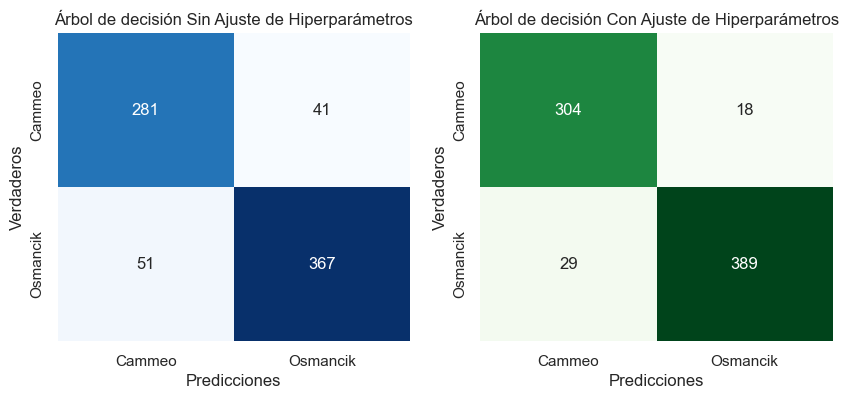

In [25]:
# Grafico de comparación matriz de confusión
graf_matriz_confusion(pred_values_tree, pred_values_tree_hp, "Árbol de decisión")

¿Como queda el arbol de decisión con los hiper-parametros?

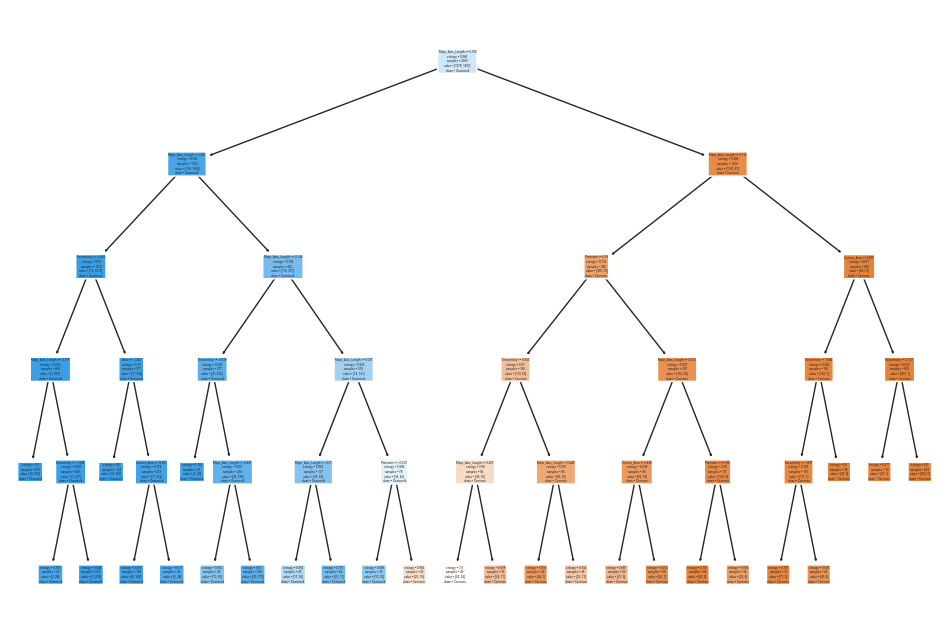

In [26]:
from sklearn.tree import plot_tree

plt.figure(figsize=(12,8))
plot_tree(best_model_tree, 
          filled=True, 
          rounded=True, 
          class_names=['Cammeo', 'Osmancik'], # Ajusta según tus clases
          feature_names=X.columns.tolist())   # Asegúrate de que 'X' sea tu conjunto de características

plt.show()

In [27]:
print("Arbol de decisión sin hiper-parámetros: ")
print(f"Tree accuracy: {round(accuracy_score(y_test, pred_values_tree), 4)}")
print(f"Tree f1 score: {round(f1_score(y_test, pred_values_tree), 4)}")
print(f"Tree precision: {round(precision_score(y_test, pred_values_tree), 4)}")
print(f"Tree recall: {round(recall_score(y_test, pred_values_tree), 4)}")
print(" ")
print("Arbol de decisión con hiper-parámetros: ")
print(f"Tree HP accuracy: {round(accuracy_score(y_test, pred_values_tree_hp), 4)}")
print(f"Tree HP f1 score: {round(f1_score(y_test, pred_values_tree_hp), 4)}")
print(f"Tree HP precision: {round(precision_score(y_test, pred_values_tree_hp), 4)}")
print(f"Tree HP recall: {round(recall_score(y_test, pred_values_tree_hp), 4)}")


Arbol de decisión sin hiper-parámetros: 
Tree accuracy: 0.8757
Tree f1 score: 0.8886
Tree precision: 0.8995
Tree recall: 0.878
 
Arbol de decisión con hiper-parámetros: 
Tree HP accuracy: 0.9365
Tree HP f1 score: 0.943
Tree HP precision: 0.9558
Tree HP recall: 0.9306


El modelo árbol de decisión final, entrenado con los hiper-parámetros optimizados, logro los siguientes resultados en el conjunto de prueba:

- `Accuracy`: `93.6%` mejorando en un 6% aproximadamente, respecto del modelo inicial.
- `F1-Score`: `93%` para Cammeo, `94%` para Osmancik. Mejorando la clasificación en la clase Osmancik y Cammeo.
- `Precision`: `91%` para Cammeo, `96%` para Osmancik. Mejorando la clasificación en la clase Osmancik y Cammeo.
- `Recall`: `94%` para Cammeo, `93%` para Osmancik. Mejorando la clasificación en la clase Osmancik y Cammeo.

### `Conclusión`


- Se destaca que los dos modelos desarrollados y optimizados con hiper-parámetros tienen rendimientos muy altos, con accuracy entorno al 94% lo cual indicaría valores de predicciones bastante bueno.  Pero es necesario considerar el problema específico, de manera de tener otras métricas de evaluación como el recall o el F1 score.

- Desde el punto de vista del Recall, el mejor rendimiento es del SVM con 93.5% (versus 93.1% del árbol de decisiones) y este debe ser el modelo seleccionado. Es necesario considerar que el recall es importantes para temas de enfermedades o decisiones de vida o muerte, caso que no aplica para este estudio. De todas maneras, si la mala selección impacta a la cadena productiva arroz, es necesario reconsiderar esta métrica.  

- Desde el punto de vista de la precisión, el mejor rendimiento es del árbol de decisiones con 95.6% (versus 95.1% del SVM). Es necesario considerar que la precisión es un indicador de la eficiencia de predecir datos positivos, minimizando los falsos positivos.

- Se destaca la considerable mejora que tiene el modelo de "Árbol de decisiones", después de una búsqueda de hiper-parámetros óptimos, donde el accuracy sube 6% con este proceso. Es necesario volver a recalcar que computacionalmente es el menos costoso (para para esta data no hace diferencia, ya que estamos trabajado con cerca de 4.000 datos), pero es una variable para considerar en un conjunto de datos más grande.

- Se realizó una búsqueda de hiper-parámetros utilizando GridSearchCV para el modelo SVM y RandomizedSearchCV para el Árbol de decisión. Este último enfoque fue especialmente beneficioso, ya que permitió explorar amplios rangos de hiper-parámetros, ofreciendo flexibilidad para probar diversas combinaciones si se deseaba. Sin embargo, es importante señalar que el coste computacional asociado al uso de RandomizedSearchCV para la SVM era prohibitivo en el contexto de nuestras capacidades computacionales disponibles para este análisis.

- Considerando los puntos anteriores y destacando el buen rendimiento de los dos modelos, se selecciona el árbol de decisiones principalmente por su adaptabilidad a otros conjuntos de datos (mejor rendimiento y fácil modificación). Además, el sobre entrenamiento es un factor que se puede controlar fácilmente con el hiper-parámetro de la profundidad del árbol. 

- Respecto de la pregunta, ¿si nuestro modelo, es un buen modelo?, nosotros diríamos que si lo es. El modelo puede converger bien y ha mejorado significativamente tras la optimización de hiper-parámetros. También generaliza bien a nuevos datos mediante validación cruzada. Hemos identificado variables importantes y hemos trabajado con ellas. Además, la consideración del costo computacional muestra que los árboles de decisión tienen una ventaja sobre modelos como SVM, especialmente en contextos que involucran grandes volúmenes de datos. Esta eficiencia computacional no solo asegura una ejecución más rápida, sino que también promete escalabilidad y practicidad si es que el modelo lo requiere. En conjunto, estas cualidades refuerzan la confianza en nuestro modelo como solución eficaz y eficiente para el análisis predictivo, que logra un equilibrio entre precisión, generalización y viabilidad operativa.
